In [21]:
try:
    ctx = PIPELINE_CONTEXT
except NameError:
    import os
    ctx = {
        "params": {},
        "artifacts": {
            "dir": "artifacts",
            "processed_data": "artifacts/processed.parquet",
            "model_file": "artifacts/kmeans_model.joblib",
            "scaler_file": "artifacts/scaler.joblib",
            "pca_file": "artifacts/pca.joblib",
            "cluster_summary": "artifacts/cluster_summary.json",
            "elbow_plot": "artifacts/elbow_plot.png",
            "silhouette_plot": "artifacts/silhouette_plot.png",
            "db_plot": "artifacts/db_plot.png",
            "ch_plot": "artifacts/ch_plot.png",
            "selection": "artifacts/selection.json",
            "features": "artifacts/features.json",
            "rf": "artifacts/rf_surrogate.pkl",
            "feature_cols": "artifacts/feature_cols.pkl",
            "X_test": "artifacts/X_test.parquet",
            "y_test": "artifacts/y_test.parquet",
            "shap_values": "artifacts/shap_values.pkl",
            "shap_arr": "artifacts/shap_arr.npy",
            "expected_vals": "artifacts/expected_vals.npy",
            "global_importance": "artifacts/global_importance.csv"
        },
        "data_dir": "data",
    }

from pathlib import Path
import json

P = ctx.get("params", {})
PATHS = ctx.get("artifacts", {})
DATA_DIR = ctx.get("data_dir", "data")
Path(PATHS["dir"]).mkdir(parents=True, exist_ok=True)

def save_json(obj, path):
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2, default=float)

def load_json(path, default=None):
    p = Path(path)
    if p.exists():
        return json.loads(p.read_text())
    return {} if default is None else default


**Imports**


In [22]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score, accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import itertools
from scipy.optimize import linear_sum_assignment
from tqdm.auto import tqdm
import joblib
import json
from pathlib import Path
import duckdb
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import shap

**Data Loading**

In [23]:
df_pca = pd.read_csv('df_pca.csv', index_col=0)
print("df_pca shape:", df_pca.shape)

df_full = pd.read_csv('player_features_cleaned.csv')
print("player_features_cleaned shape:", df_full.shape)

df_clean = pd.read_csv('df_clean.csv')
print("df_clean shape:", df_clean.shape)

df_pca shape: (1226, 13)
player_features_cleaned shape: (2130, 81)
df_clean shape: (1226, 81)


In [24]:
print("df_pca head:")
print(df_pca.head())

df_pca head:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  6.526541 -3.872125  0.817565  0.291194 -2.089165  0.651317 -2.315732   
1  5.206259  5.644737  0.389819  0.382700  3.113830  0.462240  0.369287   
2  1.748806  4.562881 -1.618118  1.292488  2.827217 -0.168391  1.756015   
3 -1.761627 -4.025482  1.055769 -1.220598 -1.014961 -0.034838  1.154448   
4 -2.618402  2.079629  1.410651 -0.566772 -2.223100  2.342897  0.462861   

        PC8       PC9      PC10  player_number_ind       player_ind  player_id  
0 -0.361181  1.192803  0.868623                 35     Kayla Grimme          0  
1 -0.495606  0.266081  0.210112                 15      Amani Tatum          1  
2  1.224152 -0.429847  1.392651                  2      Gabby Cajou          2  
3  2.071032 -1.458000 -0.346248                 30     Mikki Guiton          3  
4 -0.055167  0.239847 -1.037189                 14  Taylor Williams          4  


In [25]:
# pull the PC columns into a NumPy array
pc_cols   = [c for c in df_pca.columns if c.startswith('PC')]
X_cluster = df_pca[pc_cols].values


In [26]:
print(df_clean.columns)

Index(['college', 'season', 'player_number_ind', 'player_ind', 'gp_ind',
       'gs_ind', 'minutes_tot_ind', 'scoring_pts_ind', 'rebounds_tot_ind',
       'ast_ind', 'stl_ind', 'blk_ind', 'to_ind', 'pts_per40', 'reb_per40',
       'ast_per40', 'stl_per40', 'blk_per40', 'to_per40', 'eFG_pct', 'TS_pct',
       'USG_pct', 'ORB_pct', 'DRB_pct', 'AST_pct', 'AST_per_TO',
       '3pt_3pt_pct_ind', 'three_per40', 'threeA_per40', 'three_per100',
       'threeA_rate', 'DRCR', 'STL_TO_ratio', 'def_stops_per100', 'DPMR',
       'TUSG_pct', 'Gravity', 'PPT', 'Spacing', 'Assist_to_Usage', 'APC',
       'PEF', 'OEFF', 'TOV_pct', 'SEM', 'PEI', 'BoxCreation', 'OLI', 'IPM',
       'threeA_per100', '2pt_pct', 'FTr', 'PPP', 'possessions',
       'scoring_pts_per100', 'ast_per100', 'rebounds_tot_per100', 'stl_per100',
       'blk_per100', 'to_per100', 'mins_per_game', 'pts_per_game',
       'ast_per_game', 'reb_per_game', 'stl_per_game', 'blk_per_game',
       'to_per_game', 'scoring_pts_share', 'ast_share

**K-MEANS CLUSTERING**



In [ ]:
# K-Means Elbow, Silhouette, Davies–Bouldin & Calinski–Harabasz Sweep

ks = list(range(6, 50))    
inertias = []
sil_scores = []
db_scores = []
ch_scores = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k = km.fit_predict(X_cluster)
    
    # Inertia
    inertias.append(km.inertia_)
    
    # Guards for metrics that require at least 2 non-empty clusters
    if len(np.unique(labels_k)) > 1:
        sil = silhouette_score(X_cluster, labels_k)
        db  = davies_bouldin_score(X_cluster, labels_k)
        ch  = calinski_harabasz_score(X_cluster, labels_k)
    else:
        sil, db, ch = np.nan, np.nan, np.nan
    
    sil_scores.append(sil)
    db_scores.append(db)
    ch_scores.append(ch)

# Elbow plot (save)
plt.figure(figsize=(6,4))
plt.plot(ks, inertias, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("K-Means Elbow")
plt.tight_layout()
plt.savefig(PATHS["elbow_plot"], dpi=144)
plt.close()

# Silhouette plot (save)
plt.figure(figsize=(6,4))
plt.plot(ks, sil_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.title("K-Means Silhouette vs. k")
plt.tight_layout()
plt.savefig(PATHS["silhouette_plot"], dpi=144)
plt.close()

# Davies–Bouldin plot (save) - lower is better
plt.figure(figsize=(6,4))
plt.plot(ks, db_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Davies–Bouldin Index (↓)")
plt.title("Davies–Bouldin vs. k")
plt.tight_layout()
plt.savefig(PATHS["db_plot"], dpi=144)
plt.close()

# Calinski–Harabasz plot (save) - higher is better
plt.figure(figsize=(6,4))
plt.plot(ks, ch_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Calinski–Harabasz (↑)")
plt.title("Calinski–Harabasz vs. k")
plt.tight_layout()
plt.savefig(PATHS["ch_plot"], dpi=144)
plt.close()

# Choose best_k by silhouette
best_k = ks[int(np.nanargmax(sil_scores))]
print(f"Best k by silhouette score: {best_k} with score {np.nanmax(sil_scores):.4f}")

# Persist selection and (optionally) metric snapshots
selected = load_json(PATHS["selection"], default={})
selected["best_k"] = int(best_k)
selected["metrics"] = {
    "k": ks,
    "inertia": inertias,
    "silhouette": sil_scores,
    "davies_bouldin": db_scores,
    "calinski_harabasz": ch_scores,
    "plots": {
        "elbow": str(PATHS["elbow_plot"]),
        "silhouette": str(PATHS["silhouette_plot"]),
        "davies_bouldin": str(PATHS["db_plot"]),
        "calinski_harabasz": str(PATHS["ch_plot"]),
    }
}
save_json(selected, PATHS["selection"])
print("Saved best_k and metrics to:", PATHS["selection"], "-> best_k:", selected["best_k"])

# avoid accidental reuse of a stale 'labels'
try:
    del labels
except NameError:
    pass


Best k by silhouette score: 8 with score 0.1349
Saved best_k and metrics to: artifacts/selection.json -> best_k: 8


In [28]:
# Stability analysis

k = best_k  # use your chosen k
print(k)
n_runs = 20
labels_list = []

for seed in range(n_runs):
    km = KMeans(n_clusters=k, random_state=seed, n_init=10).fit(X_cluster)
    labels_list.append(km.labels_)

# Compare all pairs of clusterings using Adjusted Rand Index
stability_scores = []
for i in range(n_runs):
    for j in range(i+1, n_runs):
        ari = adjusted_rand_score(labels_list[i], labels_list[j])
        stability_scores.append(ari)

#AVG ARI CLOSE TO 1 = GOOD
print(f"Average ARI across {n_runs} runs: {np.mean(stability_scores):.3f}")
print(f"Min ARI: {np.min(stability_scores):.3f}, Max ARI: {np.max(stability_scores):.3f}")


8
Average ARI across 20 runs: 0.713
Min ARI: 0.522, Max ARI: 0.968


k=8, silhouette = 0.135
Centroids:
         pts_per40  eFG_pct  AST_per_TO  reb_per40  stl_per40  blk_per40
cluster                                                                 
0            -0.25    -0.29       -0.83       0.91      -0.43       0.88
1             0.81     0.40       -0.36       1.09       0.02       0.82
2             0.48     0.49        0.15      -0.70      -0.22      -0.43
3            -1.55    -0.27        2.03      -0.64       0.33      -0.54
4            -0.05     1.01       -0.19       0.52       0.23       0.36
5            -0.60    -0.87       -0.16      -0.57       0.01      -0.60
6            -0.57    -0.48       -0.17      -0.62      -0.54      -0.30
7             0.69     0.21        0.74       0.03       1.19      -0.32


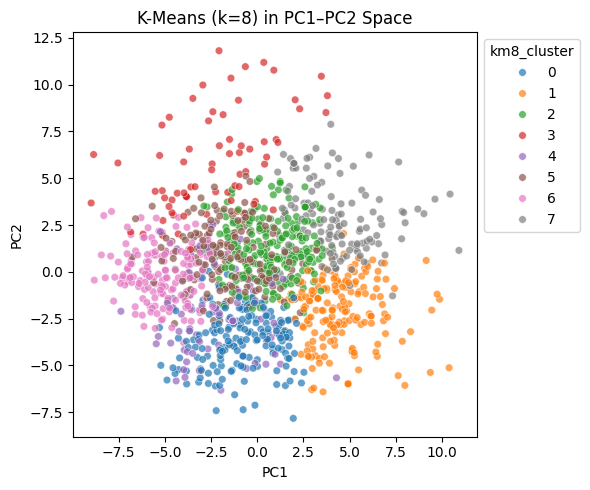

Saved K Means model to: artifacts/kmeans_model.joblib
Saved: artifacts/cluster_summary.json


In [ ]:
# K-Means Clustering

# make sure we have the PC matrix
X_cluster = df_pca[pc_cols].values
col = f'km{best_k}_cluster'

# Fit *fresh* at best_k
kmeans_best = KMeans(n_clusters=int(best_k), random_state=42, n_init=10)
labels_best = kmeans_best.fit_predict(X_cluster)

# Attach labels to both dataframes
df_pca[col]   = labels_best
df_clean[col] = labels_best



# Silhouette for the chosen model
sil_best = silhouette_score(X_cluster, labels_best)
print(f"k={best_k}, silhouette = {sil_best:.3f}")

# Basic centroids on key stats (optional)
key_stats = ['pts_per40','eFG_pct','AST_per_TO','reb_per40','stl_per40','blk_per40']
cent = (
    df_clean.groupby(col)[key_stats]
    .mean()
    .round(2)
    .rename_axis('cluster')
)
print("Centroids:")
print(cent.to_string())

# Scatter in PC1–PC2 (use the correct labels)
plt.figure(figsize=(6,5))
sns.scatterplot(
    x=df_pca['PC1'].values,
    y=df_pca['PC2'].values,
    hue=labels_best,                 
    palette='tab10',
    s=30,
    alpha=0.7
)
plt.title(f"K-Means (k={best_k}) in PC1–PC2 Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title=col, bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

# Save the model
joblib.dump(kmeans_best, PATHS["model_file"])
print("Saved K Means model to:", PATHS["model_file"])

# Save a concise summary JSON
summary = load_json(PATHS["cluster_summary"], default={})
summary.update({
    "selected": {
        "n_clusters": int(best_k),
        "pca_components": int(load_json(PATHS["selection"]).get("n_pca", 0))
    },
    "scores": {
        "silhouette": float(sil_best)
    },
    "cluster_sizes": {str(i): int((labels_best == i).sum())
                      for i in np.unique(labels_best)}
})
save_json(summary, PATHS["cluster_summary"])
print("Saved:", PATHS["cluster_summary"])


**ARCHETYPE MATCHING**

In [30]:
# Load basketball archetypes from JSON file
def load_archetypes_from_json(path="archetypes.json", strict=False):
    """
    Load archetypes from JSON into a dict[str, list[(metric, sign)]].
    - Strips whitespace from metric names (fixes typos like 'three_per100 ').
    - Coerces `sign` to int and checks it is in {-1, 1}.
    - If strict=True, raises on problems; else collects warnings.
    """
    with open(path, "r", encoding="utf-8") as f:
        raw = json.load(f)

    loaded = {}
    warnings = []

    for name, pairs in raw.items():
        cleaned_pairs = []
        for i, pair in enumerate(pairs):
            if not isinstance(pair, (list, tuple)) or len(pair) != 2:
                msg = f"[{name}] pair {i} is not [metric, sign]: {pair}"
                if strict:
                    raise ValueError(msg)
                warnings.append(msg)
                continue

            metric = str(pair[0]).strip()
            try:
                sign = int(pair[1])
            except Exception:
                msg = f"[{name}] sign not int for metric '{metric}': {pair[1]}"
                if strict:
                    raise ValueError(msg)
                warnings.append(msg)
                continue

            if sign not in (-1, 1):
                msg = f"[{name}] sign must be -1 or 1 for metric '{metric}', got {sign}"
                if strict:
                    raise ValueError(msg)
                warnings.append(msg)
                # clamp to nearest valid
                sign = 1 if sign > 0 else -1

            cleaned_pairs.append((metric, sign))
        loaded[name] = cleaned_pairs

    if warnings:
        print("Warnings while loading archetypes:")
        for w in warnings:
            print(" -", w)
    print(f"Loaded {len(loaded)} archetypes from {path}")
    return loaded

# Load from disk -> Python dict with tuples
archetypes = load_archetypes_from_json("../data/archetypes.json")


Loaded 50 archetypes from ../data/archetypes.json


In [31]:
cluster_col   = f'km{best_k}_cluster'
cluster_labels = np.sort(df_clean[cluster_col].unique())

# Collect the metrics we actually need and z-score them (vectorized)
all_metrics = sorted({m for lst in archetypes.values() for (m, _) in lst})
present_metrics = [m for m in all_metrics if m in df_clean.columns]

X = df_clean[present_metrics].astype(float).copy()
col_means = X.mean(axis=0, skipna=True)
X = X.fillna(col_means)
col_stds = X.std(axis=0, ddof=0).replace(0.0, 1.0)  # avoid div-by-zero
Z = (X - col_means) / col_stds  # global z-score

# Cluster centroids (mean z-score per metric)
# Use the series version of groupby to avoid adding cluster column to Z
cluster_centroids = Z.groupby(df_clean[cluster_col]).mean()   # shape: (n_clusters, n_metrics)
cluster_centroids = cluster_centroids.reindex(index=cluster_labels)

# Build a rectangular score matrix for all clusters × all archetypes (vectorized)
def archetype_weights(n, base=0.5):
    # decreasing geometric weights from most-important → least-important
    raw = np.array([base**i for i in range(n)][::-1], dtype=float)
    return raw / raw.sum()

arch_names = list(archetypes.keys())
score_matrix = np.full((len(cluster_labels), len(arch_names)), -1e3, dtype=float)  # default if no overlap

metrics_cols = cluster_centroids.columns

for j, arch in enumerate(arch_names):
    feats = [m for m, _ in archetypes[arch] if m in metrics_cols]
    if not feats:
        continue
    # indices in the archetype's list that actually exist
    idxs_in_arch = [i for i, (m, _) in enumerate(archetypes[arch]) if m in metrics_cols]
    # weight mask (renormalized over present features)
    w_full = archetype_weights(len(archetypes[arch]))
    w = w_full[idxs_in_arch]
    w = w / w.sum()

    # signs aligned to feats
    signs = np.array([s for (m, s) in archetypes[arch] if m in metrics_cols], dtype=float)
    # Z-scores for all clusters over these feats
    C = cluster_centroids.loc[:, feats].to_numpy()  # shape: (n_clusters, len(feats))
    # weighted sum per cluster
    # multiply by sign (direction) then dot with weights
    scores = (C * signs) @ w
    score_matrix[:, j] = scores

# Solve one rectangular assignment: each cluster maps to a unique archetype
# We want to maximize score, so minimize negative score
cost = -score_matrix
row_ind, col_ind = linear_sum_assignment(cost)  # works with rectangular matrices

best_mapping = {int(cluster_labels[r]): arch_names[c] for r, c in zip(row_ind, col_ind)}
best_total   = score_matrix[row_ind, col_ind].sum()

print("Best total score:", best_total)
print("Cluster -> Archetype")
for cl in cluster_labels:
    arch = best_mapping.get(int(cl), None)
    print(f"{cl}: {arch}")

# Report confidence (row-wise margin between best and second-best)
row_best = score_matrix.max(axis=1)
row_second = np.partition(score_matrix, -2, axis=1)[:, -2]
confidence = {int(cluster_labels[i]): float(row_best[i] - row_second[i]) for i in range(len(cluster_labels))}

print("\nConfidence margins:")
for cl in cluster_labels:
    print(f"{cl}: {confidence[int(cl)]:.3f}")


Best total score: 8.372283974505768
Cluster -> Archetype
0: Putback Specialist
1: Rim Protector / Rebounding Big
2: Deep Range Specialist
3: Two-Way Guard
4: Corner Specialist
5: Non-Impact Role Player
6: Floor General
7: Transition Creator

Confidence margins:
0: 0.204
1: 0.158
2: 0.319
3: 0.413
4: 0.130
5: 0.820
6: 0.068
7: 0.023


In [ ]:
# Scoring Sytem 0-100%
score_df = pd.DataFrame(score_matrix, index=cluster_labels, columns=arch_names)

row_labels = list(score_df.index)
col_labels = list(score_df.columns)

assigned = []
cluster_map=dict()
for cl in row_labels:
    icl = int(cl)
    arch = best_mapping.get(icl)
    if arch is None:
        # belt-and-braces fallback if something slipped through
        j = int(np.nanargmax(score_df.loc[cl].values))
        arch = col_labels[j]
        best_mapping[icl] = arch
    raw = float(score_df.loc[cl, arch])
    pct = float(np.clip(raw, 0.0, 1.0)) * 100.0
    assigned.append({
        "cluster":   icl,
        "archetype": arch,
        "raw_score": raw,
        "match %":   f"{pct:.1f}%"
    })
    cluster_map[icl] = arch

print("\nCluster -> Archetype (with match % of a perfect 1σ fit):")
display(pd.DataFrame(assigned).sort_values("cluster"))

# Update Cluster Summary
# Load the saved summary JSON
summary = load_json(PATHS["cluster_summary"], default={})

# Replace cluster numbers in "cluster_sizes" with archetype names
if "cluster_sizes" in summary:
    summary["cluster_sizes"] = {
        cluster_map.get(int(k), f"Cluster {k}"): v
        for k, v in summary["cluster_sizes"].items()
    }

# Add match percentage
if "match_percentages" not in summary:
    summary["match_percentages"] = {}
for item in assigned:
    summary["match_percentages"][item["archetype"]] = item["match %"]

# Save updated summary
save_json(summary, PATHS["cluster_summary"])
print("Updated with archetypes:", PATHS["cluster_summary"])



Cluster -> Archetype (with match % of a perfect 1σ fit):


,cluster,archetype,raw_score,match_%
0,0,Putback Specialist,1.075206,100.0%
1,1,Rim Protector / Rebounding Big,1.182779,100.0%
2,2,Deep Range Specialist,0.984065,98.4%
3,3,Two-Way Guard,1.281805,100.0%
4,4,Corner Specialist,1.037791,100.0%
5,5,Non-Impact Role Player,0.894580,89.5%
6,6,Floor General,0.843962,84.4%
7,7,Transition Creator,1.072095,100.0%


Updated with archetypes: artifacts/cluster_summary.json


In [33]:
# Add human-readable archetype per player
cluster_col = "cluster" if "cluster" in df_clean.columns else f"km{int(best_k)}_cluster"
df_clean["Archetype"] = (
    df_clean[cluster_col].astype(int).map(best_mapping).fillna(df_clean[cluster_col].astype(str))
)
df_clean["cluster"] = df_clean[cluster_col].astype(int)  # ensure generic cluster column exists
df_clean["Archetype"] = df_clean["cluster"].map(best_mapping).fillna(df_clean["cluster"].astype(str))



Using 76 numeric feature(s):
['gp_ind', 'gs_ind', 'minutes_tot_ind', 'scoring_pts_ind', 'rebounds_tot_ind', 'ast_ind', 'stl_ind', 'blk_ind', 'to_ind', 'pts_per40', 'reb_per40', 'ast_per40', 'stl_per40', 'blk_per40', 'to_per40', 'eFG_pct', 'TS_pct', 'USG_pct', 'ORB_pct', 'DRB_pct'] ...

Surrogate performance vs k-means labels -> Acc: 0.876 | Macro-F1: 0.864

Class-wise report:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86        44
           1       0.88      0.98      0.93        46
           2       0.87      0.90      0.88        58
           3       1.00      0.72      0.84        18
           4       0.93      0.67      0.78        21
           5       0.88      0.86      0.87        44
           6       0.93      0.95      0.94        41
           7       0.84      0.77      0.81        35

    accuracy                           0.88       307
   macro avg       0.89      0.85      0.86       307
weighted avg       0.88  

scoring_pts_ind       0.018020
OLI                   0.015937
game_score            0.014733
possessions           0.012945
pts_per_game          0.010164
TOV_pct               0.010051
rebounds_tot_ind      0.009022
def_stops_per100      0.008138
ast_ind               0.007197
threeA_rate           0.007058
reb_per40             0.007054
OEFF                  0.006865
scoring_pts_share     0.006727
to_ind                0.006564
rebounds_tot_share    0.006307
minutes_tot_ind       0.006298
threeA_per100         0.005885
three_per100          0.005753
PEI                   0.005654
2pt_pct               0.005337
dtype: float64

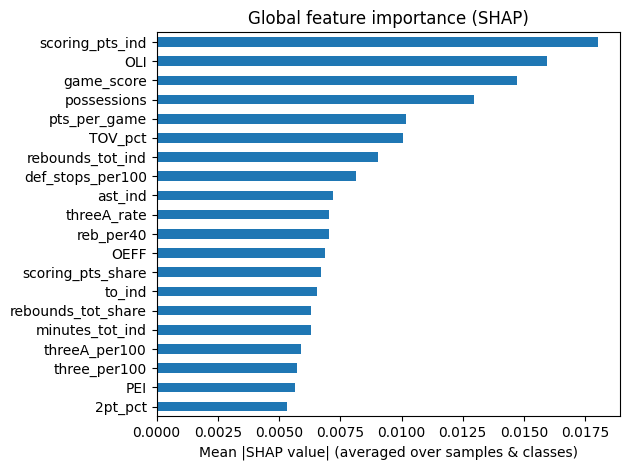

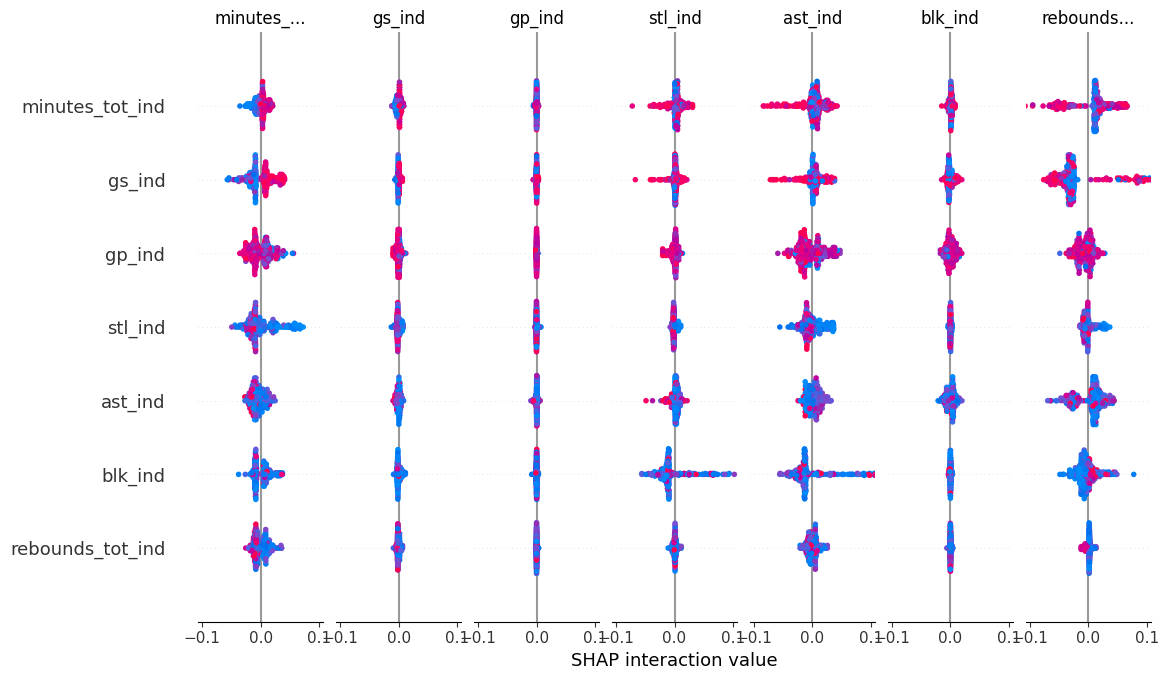


Top five features for Putback Specialist:


OLI                0.080128
scoring_pts_ind    0.039460
threeA_rate        0.031110
possessions        0.025700
reb_per40          0.024673
dtype: float64

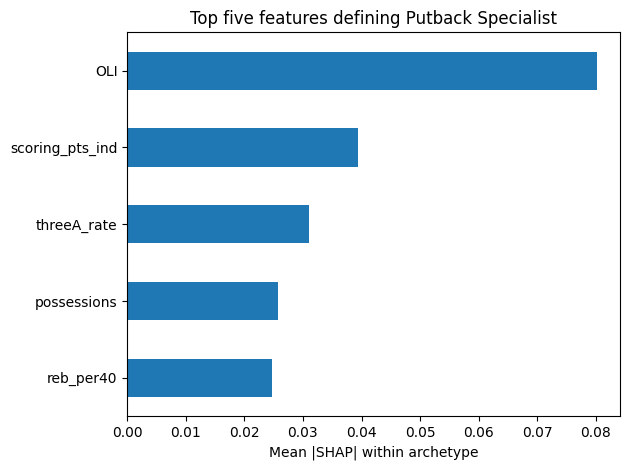


Top five features for Rim Protector / Rebounding Big:


rebounds_tot_ind      0.063032
scoring_pts_ind       0.054792
game_score            0.050682
OLI                   0.050490
rebounds_tot_share    0.040257
dtype: float64

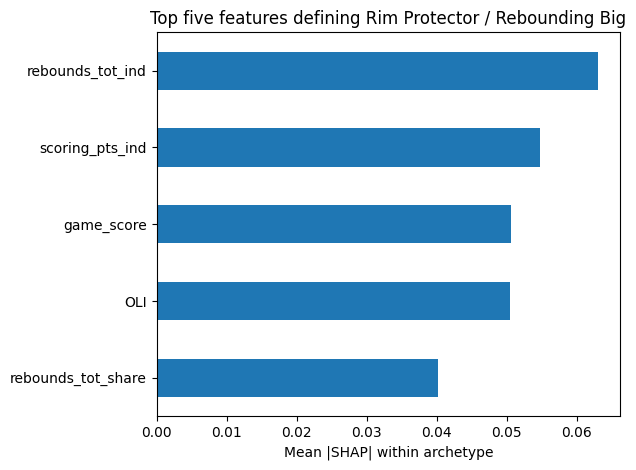


Top five features for Deep Range Specialist:


scoring_pts_ind     0.047093
TOV_pct             0.030579
pts_per_game        0.029055
game_score          0.025695
rebounds_tot_ind    0.025221
dtype: float64

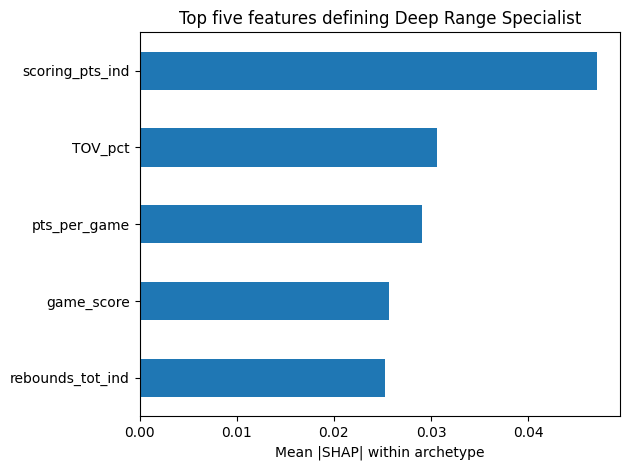


Top five features for Two-Way Guard:


ast_per100         0.045051
OLI                0.039090
Assist_to_Usage    0.037295
ast_per_fgm        0.034123
scoring_pts_ind    0.026007
dtype: float64

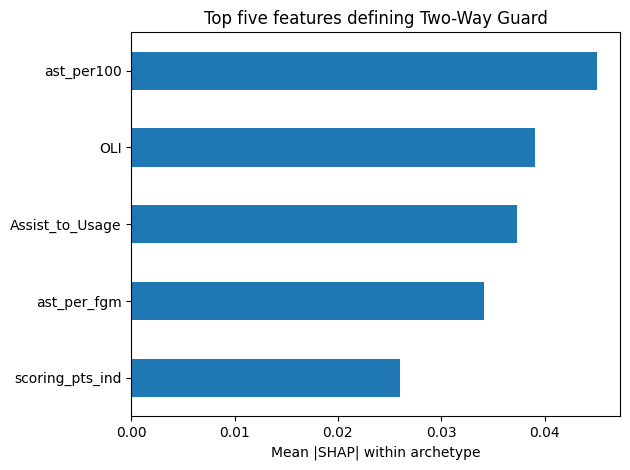


Top five features for Corner Specialist:


OEFF           0.032808
PEI            0.032231
possessions    0.027327
2pt_pct        0.026234
PPP            0.023585
dtype: float64

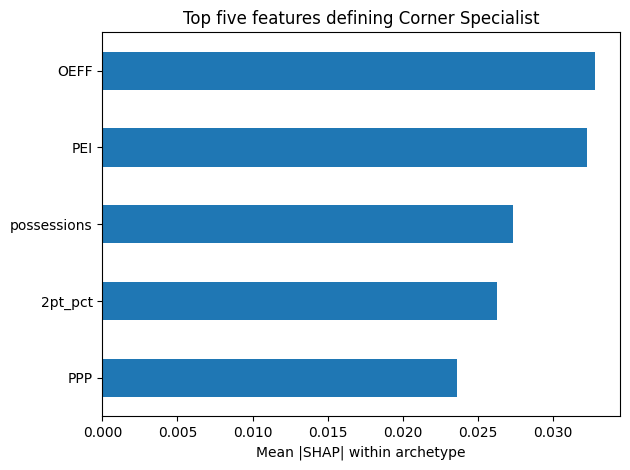


Top five features for Non-Impact Role Player:


game_score            0.049507
scoring_pts_per100    0.024631
scoring_pts_ind       0.024613
to_ind                0.024607
OLI                   0.023977
dtype: float64

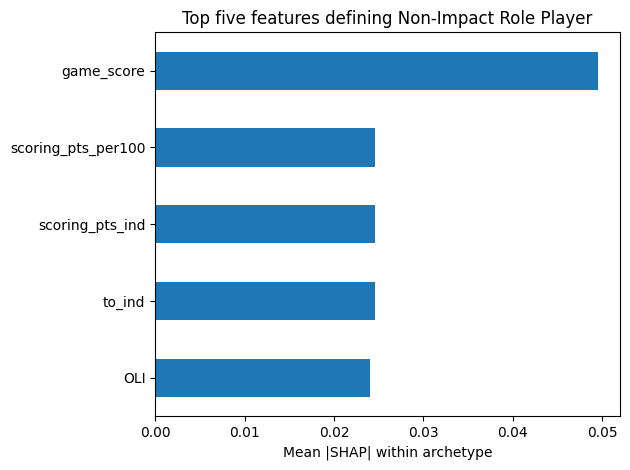


Top five features for Floor General:


scoring_pts_ind    0.045499
TOV_pct            0.044075
possessions        0.042841
to_ind             0.035142
game_score         0.034824
dtype: float64

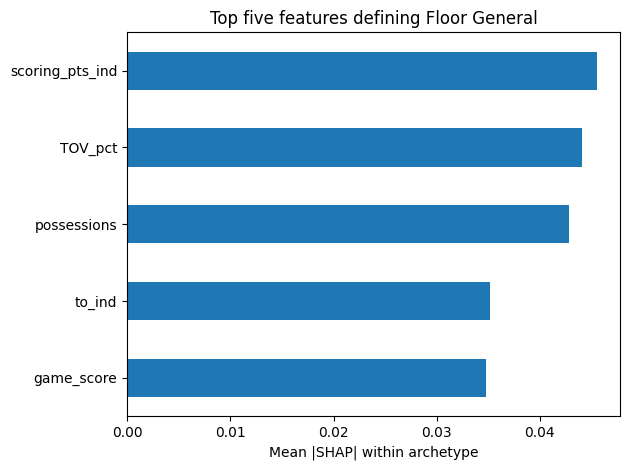


Top five features for Transition Creator:


ast_ind            0.037295
scoring_pts_ind    0.036611
ast_per_game       0.032819
game_score         0.032682
APC                0.031080
dtype: float64

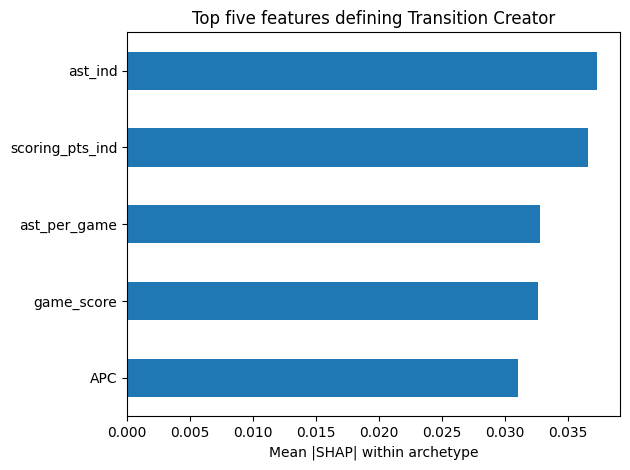


Local explanation for index=410 — predicted archetype: Deep Range Specialist (Cluster 2)


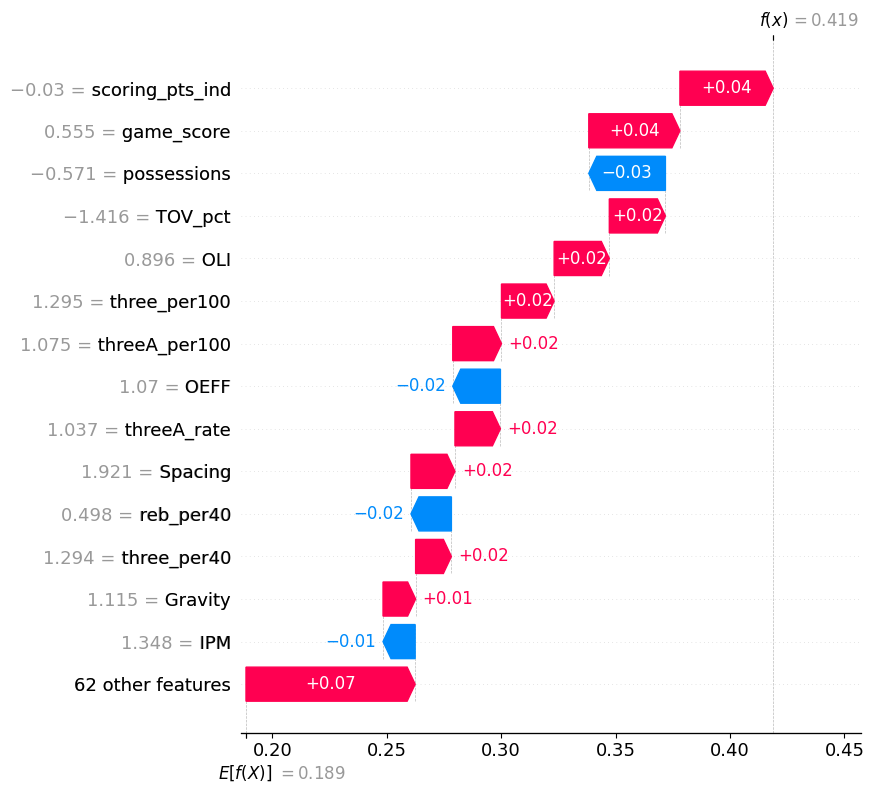

Saved SHAP artifacts


In [ ]:
# SHAP for k-means clusters via a surrogate RandomForest 


# Data & features
df_xai = df_clean.copy()
label_col = 'cluster'
assert label_col in df_xai.columns, "Expected df_clean to contain a 'cluster' column."

# Build cluster -> archetype mapping (majority label per cluster)
if 'Archetype' in df_xai.columns:
    cl_to_arch = (
        df_xai[['cluster', 'Archetype']]
        .dropna()
        .groupby('cluster')['Archetype']
        .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[0])
        .to_dict()
    )
else:
    cl_to_arch = {}
def cluster_name(k: int) -> str:
    try:
        return str(cl_to_arch.get(int(k), f"Cluster {int(k)}"))
    except Exception:
        return f"Cluster {k}"

# Select numeric features and exclude IDs / labels / meta
drop_like = ['player_number_ind', 'player_ind', 'player_id', 'college', 'season', 'archetype', 'cluster']
cols_num = df_xai.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in cols_num if not any(k in c.lower() for k in drop_like)]

X = df_xai[feature_cols].copy()
y = df_xai[label_col].astype(int).copy()

# Clean X from infs/nans
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))

print(f"Using {len(feature_cols)} numeric feature(s):")
print(feature_cols[:20], "..." if len(feature_cols) > 20 else "")

# Train surrogate
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

rf = RandomForestClassifier(
    n_estimators=400,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Fidelity
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average='macro')
print(f"\nSurrogate performance vs k-means labels -> Acc: {acc:.3f} | Macro-F1: {f1m:.3f}")
print("\nClass-wise report:")
print(classification_report(y_test, y_pred))

# SHAP 
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test, check_additivity=False)

# Normalize SHAP into (n_samples, n_features, n_classes)
if isinstance(shap_values, list):
    arr = np.stack(shap_values, axis=2)  # (n_samples, n_features, n_classes)
    expected_vals = np.array(explainer.expected_value)
else:
    arr = np.array(shap_values)
    if arr.ndim == 2:  # (n_samples, n_features) -> add class axis
        arr = arr[:, :, None]
    expected_vals = np.array(explainer.expected_value)

n_samples, n_features, n_classes = arr.shape

# Global importance 
shap_abs_mean = np.mean(np.abs(arr), axis=(0, 2))
global_imp = pd.Series(shap_abs_mean, index=feature_cols).sort_values(ascending=False)

print("\nTop global features (by mean |SHAP|):")
display(global_imp.head(20))

plt.figure()
global_imp.head(20).iloc[::-1].plot(kind='barh')
plt.xlabel("Mean |SHAP value| (averaged over samples & classes)")
plt.title("Global feature importance (SHAP)")
plt.tight_layout()
plt.show()

# Beeswarm overview
shap.summary_plot(shap_values, X_test, show=True)

#  Per-archetype (cluster) top features
TOP_M = 10
for k in range(n_classes):
    idx_k = (y_test.values == k)
    if not idx_k.any():
        continue
    imp_k = np.mean(np.abs(arr[idx_k, :, k]), axis=0)   # (n_features,)
    s_k = pd.Series(imp_k, index=feature_cols).sort_values(ascending=False).head(TOP_M)
    arch_label = cluster_name(k)

    print(f"\nTop five features for {arch_label}:")
    display(s_k)

    plt.figure()
    s_k.iloc[::-1].plot(kind='barh')
    plt.xlabel("Mean |SHAP| within archetype")
    plt.title(f"Top five features defining {arch_label}")
    plt.tight_layout()
    plt.show()

# Local (player-level) explanation 
example_idx = X_test.index[0]
row_pos = X_test.index.get_loc(example_idx)
pred_class = int(rf.predict(X_test.loc[[example_idx]])[0])
arch_label = cluster_name(pred_class)

print(f"\nLocal explanation for index={example_idx} — predicted archetype: {arch_label} (Cluster {pred_class})")

sv_row = arr[row_pos, :, pred_class]

# expected value for the predicted class
if np.ndim(expected_vals) == 0:
    base_val = float(expected_vals)
elif np.ndim(expected_vals) == 1 and expected_vals.size >= (pred_class + 1):
    base_val = float(expected_vals[pred_class])
else:
    base_val = float(np.ravel(expected_vals)[0])

shap.plots.waterfall(
    shap.Explanation(
        values=sv_row,
        base_values=base_val,
        data=X_test.loc[example_idx].values,
        feature_names=feature_cols
    ),
    max_display=15,
    show=True
)

# Save artifacts
joblib.dump(rf, PATHS["rf"])
joblib.dump(feature_cols, PATHS["feature_cols"])
X_test.to_parquet(PATHS["X_test"])
y_test.to_frame("cluster").to_parquet(PATHS["y_test"])

joblib.dump(shap_values, PATHS["shap_values"])           
np.save(PATHS["shap_arr"], arr)                          #
np.save(PATHS["expected_vals"], expected_vals)

shap_abs_mean = np.mean(np.abs(arr), axis=(0, 2))
global_imp = pd.Series(shap_abs_mean, index=feature_cols).sort_values(ascending=False)
global_imp.to_csv(PATHS["global_importance"], header=["mean_abs_shap"])
print("Saved SHAP artifacts")


In [35]:


# Sample output
print("\nSample players with archetypes:")
display(
    df_clean[["player_ind", "season", "cluster", "Archetype"]]
    .head(10)
)

# df_clean.drop(columns=["km6_cluster",'cluster'], inplace=True)

# merge archetype onto df_full by season-specific player_id
df_out=df_full.copy()
df_out["player_id"] = df_out["player_id"].astype(int)
df_clean["player_id"] = df_clean["player_id"].astype(int)

# ensure player_id types match
df_out['player_id'] = df_out['player_id'].astype(df_clean['player_id'].dtype)

# build a lookup: player_id -> Archetype
archetype_lookup = (
    df_clean.drop_duplicates('player_id')     # just in case
            .set_index('player_id')['Archetype']
)

# players not in df_clean get "Not Enough Minutes Played"
df_out['Archetype'] = df_out['player_id'].map(archetype_lookup).fillna('Not Enough Minutes Played')

df_out.drop(columns=["player_id"], inplace=True, errors='ignore')


# save processed data to DuckDB and parquet
df_out.to_parquet(PATHS["processed_data"])
db_path = Path(PATHS["processed_data"]).with_suffix(".duckdb")  
con = duckdb.connect(str(db_path))
con.register("df_out", df_out)  # make the pandas DF visible to DuckDB
con.execute("DROP TABLE IF EXISTS processed;")
con.execute("CREATE TABLE processed AS SELECT * FROM df_out;")
con.close()


Sample players with archetypes:


,player_ind,season,cluster,Archetype
0,Kayla Grimme,2017-18,1,Rim Protector / Rebounding Big
1,Amani Tatum,2017-18,7,Transition Creator
2,Gabby Cajou,2017-18,7,Transition Creator
3,Mikki Guiton,2017-18,0,Putback Specialist
4,Taylor Williams,2017-18,6,Floor General
5,Courtney Warley,2017-18,0,Putback Specialist
6,Lizahya Morgan,2017-18,5,Non-Impact Role Player
7,Lynette Taitt,2017-18,6,Floor General
8,Sini Mäkelä,2017-18,6,Floor General
9,Kayla Grimme,2016-17,1,Rim Protector / Rebounding Big
